# Generating FBM Samples wrt Time, using FBM library

* We can observe that increasing hurst parameter, we get smoother relaisations of motion.

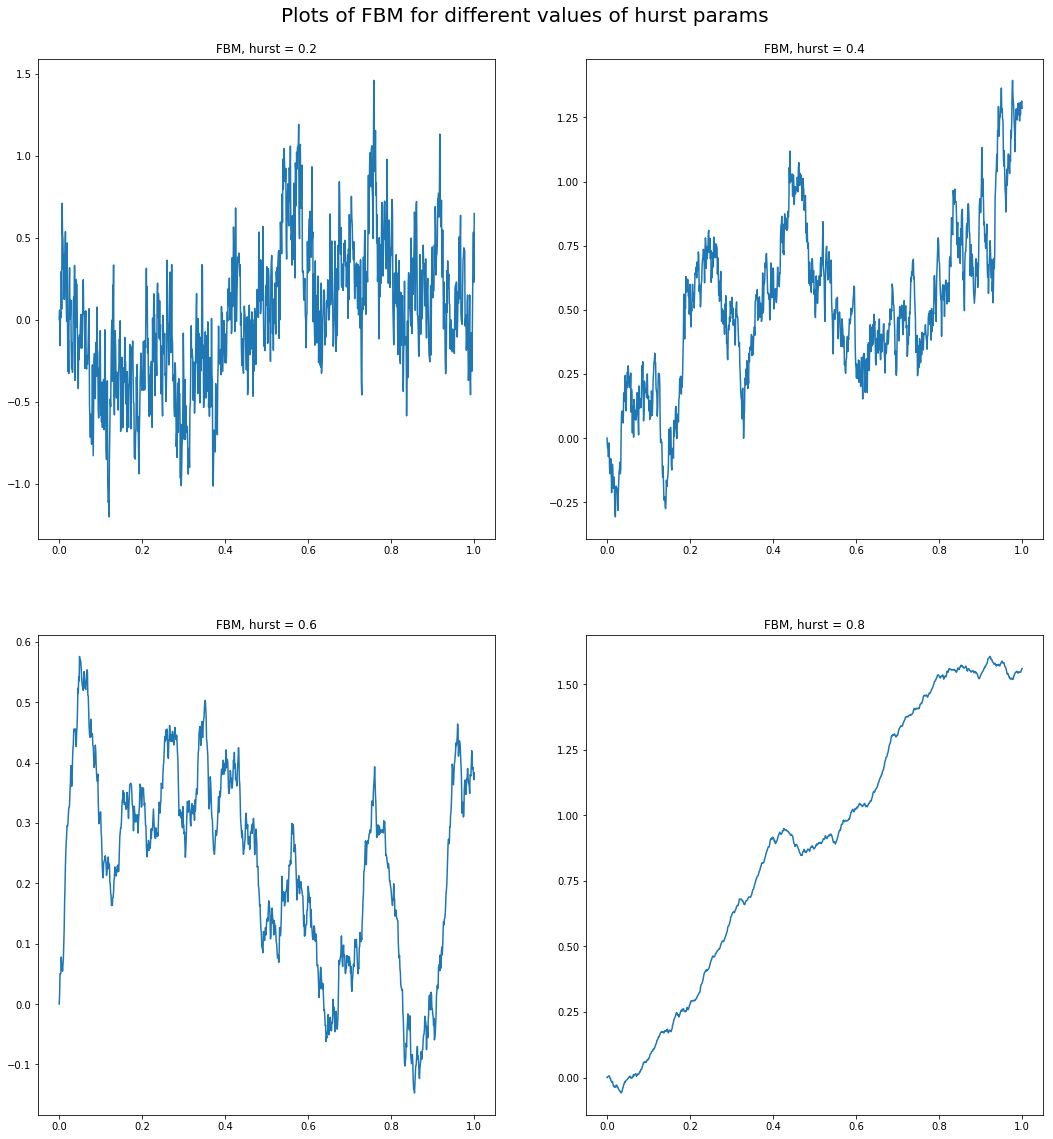

In [1]:
%matplotlib inline

from fbm import FBM
import matplotlib.pyplot as plt
import numpy as np

from scipy.fftpack import fft, ifft, fftfreq

def plt_fbm(h_param,num_samp,subplot_index=111):
    f = FBM(n=num_samp, hurst=h_param, length=1, method='cholesky')
    # Generate a fBm realization
    fbm_sample = f.fbm()

    # Get the times associated with the fBm
    t_values = f.times()
    
    ax= fig.add_subplot(subplot_index)
    ax.set_title("FBM, hurst = "+str(h_param))
    ax.plot(t_values,fbm_sample)
    #print(t_values)
    return fbm_sample

plt.rcParams['figure.figsize'] = (18, 18)
fig = plt.figure()
fig.tight_layout()
fig.subplots_adjust(top=0.94)
fbm_samps=[]
plt.suptitle("Plots of FBM for different values of hurst params",fontsize=20)
num_pts=1000
t_samp=np.linspace(0,1,num_pts+1)
fbm_samps.append(plt_fbm(0.2,num_pts,221))
fbm_samps.append(plt_fbm(0.4,num_pts,222))
fbm_samps.append(plt_fbm(0.6,num_pts,223))
fbm_samps.append(plt_fbm(0.8,num_pts,224))
plt.show()

# Plotting the FFT of FBM motion as well

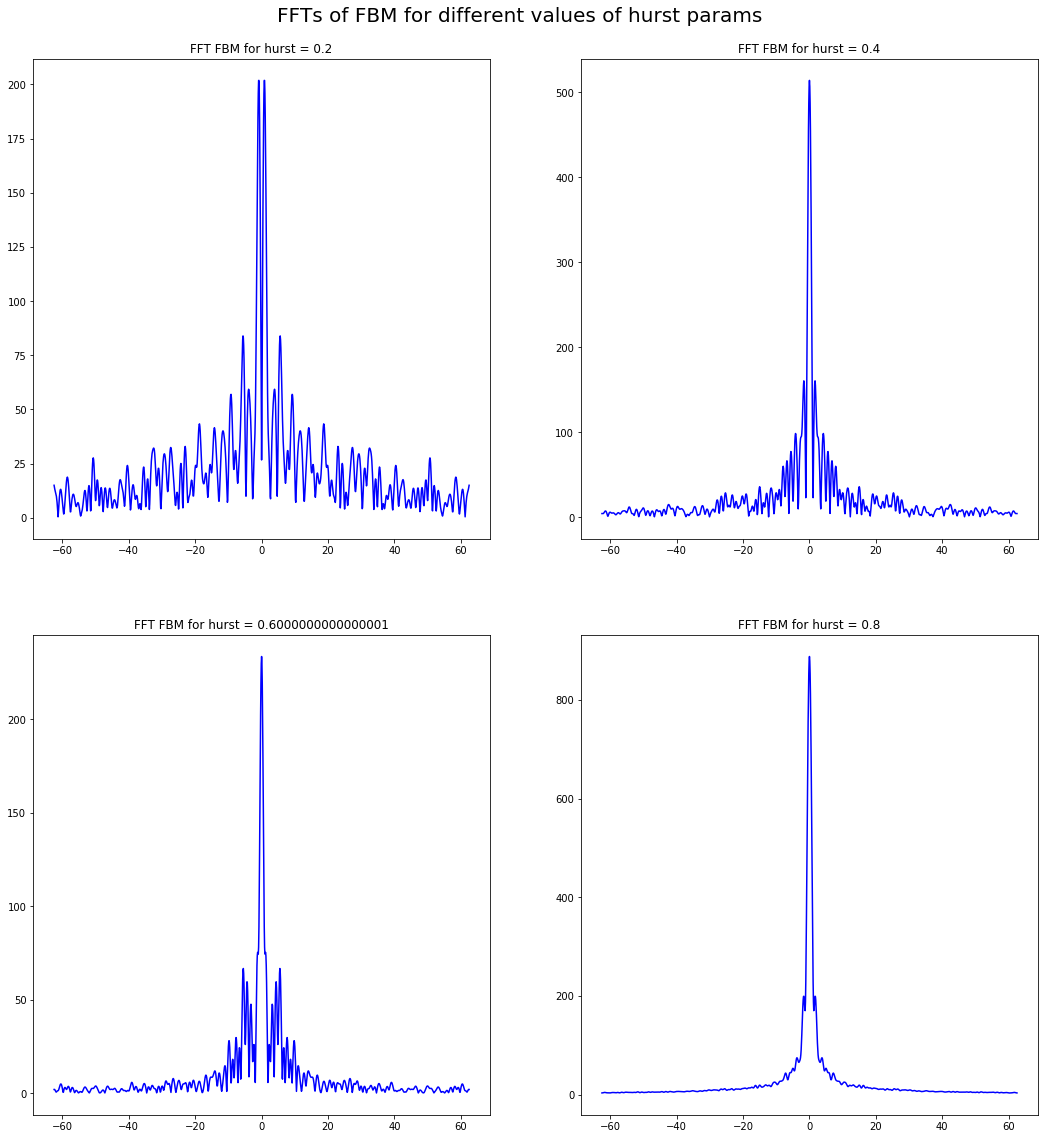

In [2]:
def plot_fft(fbm_vals,hurst,subplot_index=111):
    samp_freq=1000
    NFFT=10*t_samp.shape[0]
    zp_arr=np.append(np.array(fbm_vals),np.zeros(NFFT-len(fbm_vals)))
    fbm_freq=np.fft.fftshift(fft(zp_arr,NFFT))
    disc_w=np.linspace(-samp_freq/16,samp_freq/16,NFFT//8)
    ax= fig.add_subplot(subplot_index)
    ax.set_title("FFT FBM for hurst = "+str(hurst))
    ax.plot(disc_w,abs(fbm_freq[NFFT//2-NFFT//16:NFFT//2+NFFT//16+1]),'b')
    return fbm_freq[0:NFFT//2]

plt.rcParams['figure.figsize'] = (18, 18)
fig = plt.figure()
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.suptitle("FFTs of FBM for different values of hurst params",fontsize=20)
subplot_list=[221,222,223,224]
freq_fbm_samps=[]
for i in range(len(fbm_samps)): 
    freq_fbm_samps.append(plot_fft(fbm_samps[i],0.2*(i+1),subplot_list[i]))
plt.show()


# PCA spectrum of single FBM signals


0.510360654799


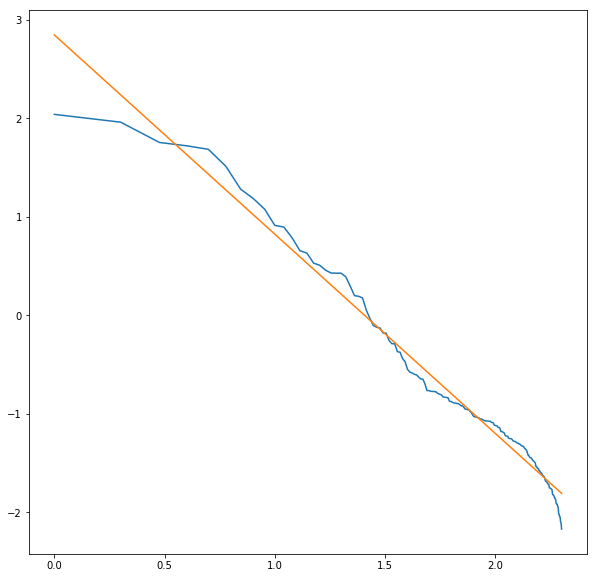

In [3]:
from scipy.ndimage.interpolation import shift
from scipy.linalg import toeplitz,inv,svd
from scipy.optimize import curve_fit

def Lf(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

M=200
H=0.6
f = FBM(n=M, hurst=H, length=0.5, method='daviesharte')
# Generate a fBm realization
fbm_sample = f.fbm()
# Get the times associated with the fBm
t_values = f.times()
#print(t_values)
# plt.plot(t_values,fbm_sample)
# plt.show()

R=np.zeros(M+1) #Autocorrelation: r[0] to r[p-1]

for k in range(M+1):
    fbm_shift=shift(fbm_sample, k, cval=0)
    R[k]=np.sum(fbm_sample*np.conjugate(fbm_shift))

AutoCorr_mat=toeplitz(R[0:M],R[0:M])

num_sim=50
for i in range(num_sim):
    f1 = FBM(n=M, hurst=H, length=0.5, method='daviesharte')
    # Generate a fBm realization
    if(i==0):
        avg_sample=f1.fgn()
    else:
        avg_sample += f1.fgn()

#mean_vec=[t_values[i]**(2*H) for i in range(0,M)]
mean_vec=avg_sample/num_sim
#print(mean_vec)
AutoCov_mat=AutoCorr_mat

U,S,V=svd(AutoCov_mat)
plt.rcParams['figure.figsize'] = (10, 10)
plt.plot(np.log10(np.arange(M)+1),np.log10(S))

expected_slope=-(2*H+1)
A,B = curve_fit(Lf,np.log10(np.arange(M)+1),np.log10(S))[0] # your data x, y to fit
print(-(A+1)/2)
plt.plot([0,np.log10(M)],[B,A*np.log10(M)+B])
plt.show()

#print(S)


513


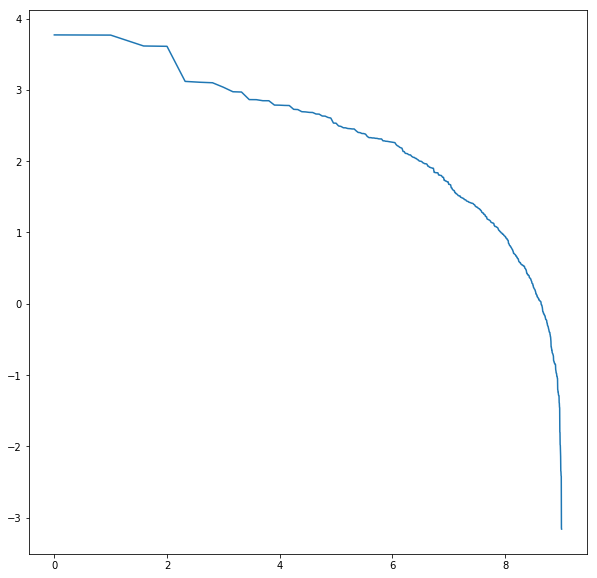

In [4]:
import pywt

def Qf(x, A, B,C): # this is your 'straight line' y=f(x)
    return A*x**2 + B*x + C

def get_wavelet_var(wavelet,H=0.3,est_sil=1):
    samp_size=1024
    f = FBM(n=samp_size, hurst=H, length=0.5, method='daviesharte')
    # Generate a fBm realization
    fbm_sample = f.fbm()
    # Get the times associated with the fBm
    t_values = f.times()
    cA, cD = pywt.dwt(fbm_sample, wavelet)
    
    M=len(cD)
    print(M)
    # plt.rcParams['figure.figsize'] = (10, 10)
    # #plt.plot(fbm_sample[::2])
    # #plt.plot(cD)
    # plt.show()
    R=np.zeros(M+1) #Autocorrelation: r[0] to r[p-1]

    for k in range(M+1):
        cD_shift=shift(cD, k, cval=0)
        R[k]=np.sum(cD*np.conjugate(cD_shift))

    AutoCorr_mat=toeplitz(R[0:M],R[0:M])

    num_sim=50
    for i in range(num_sim):
        f1 = FBM(n=samp_size, hurst=H, length=0.5, method='daviesharte')
        # Generate a fBm realization
        if(i==0):
            temp_cA,temp_cD=pywt.dwt(f1.fbm(),wavelet)
            avg_cD=temp_cD
        else:
            temp_cA1,temp_cD=pywt.dwt(f1.fbm(),wavelet)
            avg_cD += temp_cD

    #mean_vec=[t_values[i]**(2*H) for i in range(0,M)]
    mean_vec=avg_cD/num_sim
    #print(AutoCorr_mat)
    #print(np.outer(mean_vec,mean_vec))
    
    AutoCov_mat=AutoCorr_mat-np.outer(mean_vec,mean_vec)
    #print(AutoCov_mat-AutoCorr_mat)

    U,S,V=svd(AutoCov_mat)
    plt.rcParams['figure.figsize'] = (10, 10)
    #print(S)
    #print(S[::-1])
    plt.plot(np.log2(np.arange(M)+1),np.log2(S))

#     expected_slope=-(2*H+1)
#     A,B = curve_fit(Lf,np.log10(np.arange(2,M)),np.log10(S[2:]))[0] # your data x, y to fit
#     if(est_sil==0):
#         x=np.log10(np.arange(M)+1)
#         y=A*x+B
#         plt.plot(x,y)
#     print(-(A+1)/2)
#     return A,B
    #plt.plot([0,np.log10(M)],[B,A*np.log10(M)+B])

get_wavelet_var('haar')
# get_wavelet_var('db2')
# get_wavelet_var('db6')
# get_wavelet_var('db10')
# get_wavelet_var('db20')
# plt.legend(['haar','db2','db6','db10','db20'])
plt.show()

#print(S)


513
513
513
513


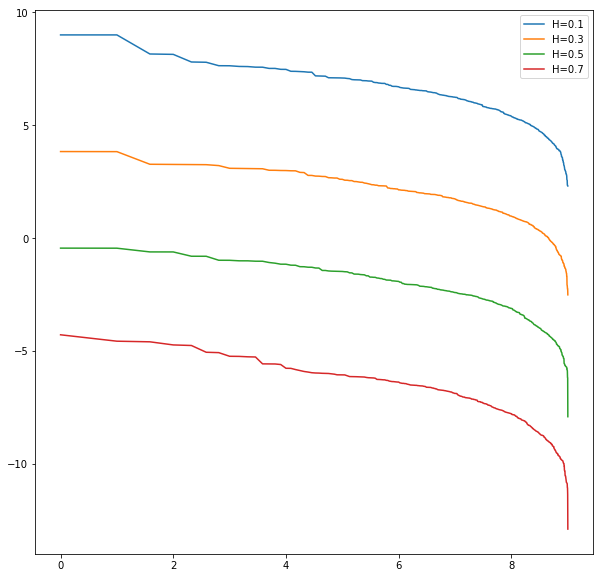

In [5]:
get_wavelet_var('haar',0.1)
get_wavelet_var('haar',0.3)
get_wavelet_var('haar',0.5)
get_wavelet_var('haar',0.7)

plt.legend(['H=0.1','H=0.3','H=0.5','H=0.7'])
plt.show()

#print(S)


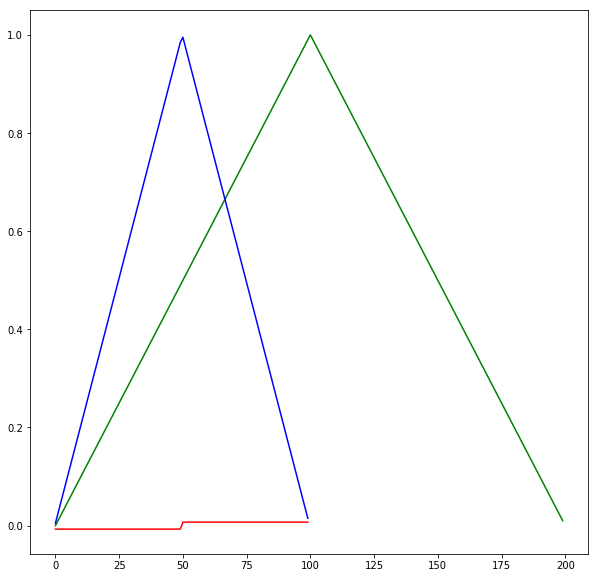

[-0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107  0.00707107  0.00707107  0.00707107  0.00707107
  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107
  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107
  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107
  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107
  0.00707107  0.00707107  0.00707107  0.00707107  0

In [6]:
tr_wave =np.zeros(200)
for i in range(200):
    tr_wave[i]= min(i,200-i)/100
tr_cA, tr_cD = pywt.dwt(tr_wave, 'haar')
plt.plot([i for i in range(len(tr_wave))], tr_wave,'g')
plt.plot([i for i in range(len(tr_cA))], tr_cA/1.414,'b')
plt.plot([i for i in range(len(tr_cD))], tr_cD,'r')
plt.show()
print(tr_cD)

250
250
250
250
0.0855008027757:0.287333320408:0.50336460927:0.720579120423:


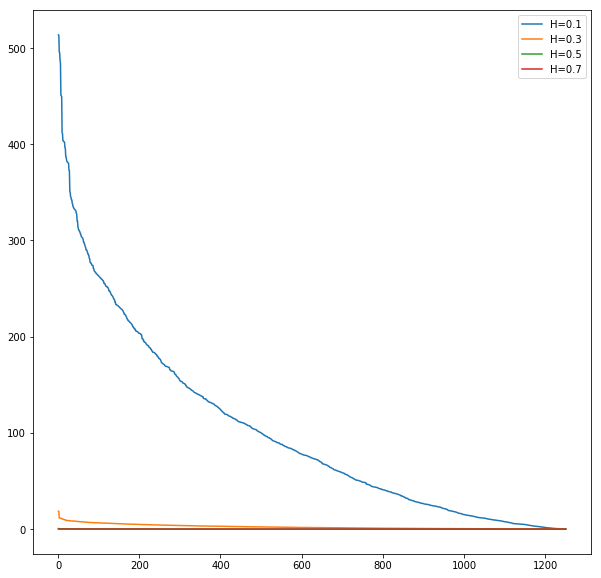

In [46]:
import pywt

def Lf(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

def Qf(x, A, B,C): # this is your 'straight line' y=f(x)
    return A*x**2 + B*x + C

def get_wavelet_var(wavelet,H=0.3,samp_size=150,est_sil=0,plot_sil=0,print_sil=0):
    
    f = FBM(n=samp_size, hurst=H, length=0.5, method='daviesharte')
    # Generate a fBm realization
    fbm_sample = f.fbm()
    # Get the times associated with the fBm
    t_values = f.times()
    cA, cD = pywt.dwt(fbm_sample, wavelet)
    
    M=len(cD)//2
    #print(M)
    AutoCorr_mat=np.zeros((M+1,M+1))
    for j in range(M+1):
        orig_seq=cD[j:M+j]
        for k in range(M+1):
            shift_seq=cD[k:M+k]
            AutoCorr_mat[j][k]=np.sum(orig_seq*np.conjugate(shift_seq))
    
    U,S,V=svd(AutoCorr_mat)
    num_elem=int(0.2*M)
    if(print_sil!=1):
        print(num_elem)
    if(est_sil!=1):
        if(num_elem%2==1):
            A,B = curve_fit(Lf,(np.arange(num_elem)+M//2-num_elem//2)\
                                ,np.log10(S[M//2-num_elem//2:M//2+num_elem//2+1]))[0] # your data x, y to fit
        else:
            A,B = curve_fit(Lf,(np.arange(num_elem)+M//2-num_elem//2)\
                            ,np.log10(S[M//2-num_elem//2:M//2+num_elem//2]))[0] # your data x, y to fit
        #print(A,B)
    if(plot_sil!=1):
        ax.plot(np.arange(M)+1\
                ,S[0:M],label=str("H="+str(H)))
        if(est_sil!=1):
            plt.plot([0,M],[B,A*(M)+B])
            
    if(est_sil!=1):
        if(print_sil!=1):
            print(A,B)
        return B
    return -0.14*np.log10(S[0])+0.465

plt.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure()
ax= fig.add_subplot(111)
h0=get_wavelet_var('haar',0.1,samp_size=5000,est_sil=1)
h1=get_wavelet_var('haar',0.3,samp_size=5000,est_sil=1)
h2=get_wavelet_var('haar',0.5,samp_size=5000,est_sil=1)
h3=get_wavelet_var('haar',0.7,samp_size=5000,est_sil=1)
print(str(h0)+":"+str(h1)+":"+str(h2)+":"+str(h3)+":")
# get_wavelet_var('haar',0.3,plot_sil=0)
# get_wavelet_var('haar',0.5,plot_sil=0)
# get_wavelet_var('haar',0.7,plot_sil=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()

51
102
204
409


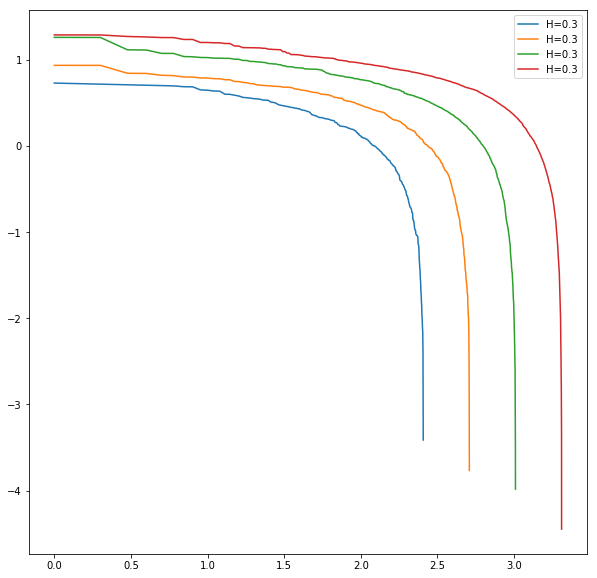

In [18]:
plt.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure()
ax= fig.add_subplot(111)
get_wavelet_var('haar',0.3,1024,est_sil=1,plot_sil=0)
get_wavelet_var('haar',0.3,2048,est_sil=1,plot_sil=0)
get_wavelet_var('haar',0.3,4096,est_sil=1,plot_sil=0)
get_wavelet_var('haar',0.3,8192,est_sil=1,plot_sil=0)
#get_wavelet_var('haar',0.3,16384,est_sil=0,plot_sil=0)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()

-0.138749469231 0.465066461184


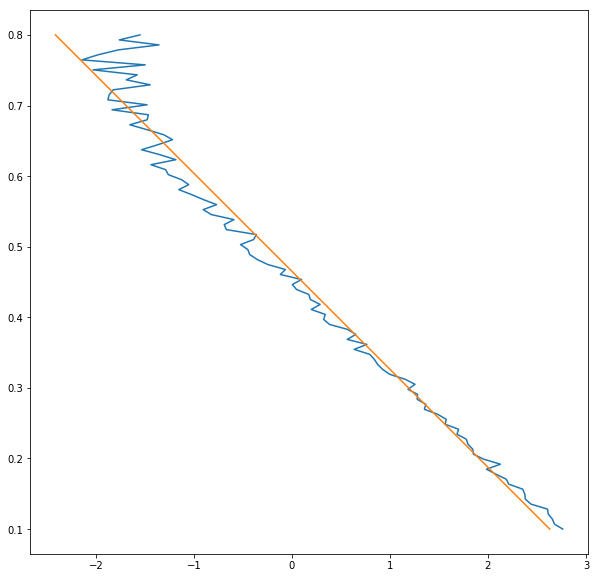

In [39]:
H_list=np.linspace(0.1,0.8,100)
intercept_vs_H=[get_wavelet_var('haar',H,5000,est_sil=1,plot_sil=1,print_sil=1) for H in H_list]
plt.rcParams['figure.figsize'] = (10, 10)
plt.plot(intercept_vs_H,H_list)
A,B = curve_fit(Lf,intercept_vs_H,H_list)[0] # your data x, y to fit
plt.plot([(0.1-B)/A,(0.8-B)/A],[0.1,0.8])
print(A,B)
plt.show()

5371.18072598 -2656.75034994


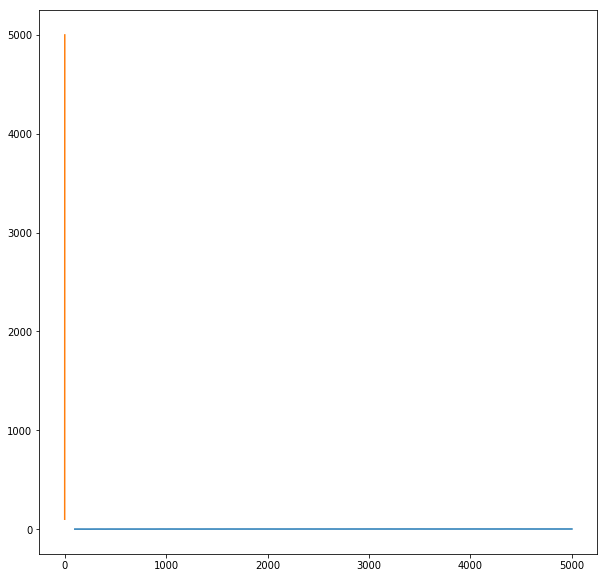

In [32]:
samp_list=np.linspace(100,5000,99)
intercept_vs_samp=[get_wavelet_var('haar',0.3,int(samp),est_sil=1,plot_sil=1,print_sil=1) for samp in samp_list]
plt.rcParams['figure.figsize'] = (10, 10)
plt.plot(samp_list,intercept_vs_samp)
A,B = curve_fit(Lf,intercept_vs_samp,samp_list)[0] # your data x, y to fit
plt.plot([(100-B)/A,(5000-B)/A],[100,5000])
print(A,B)
plt.show()

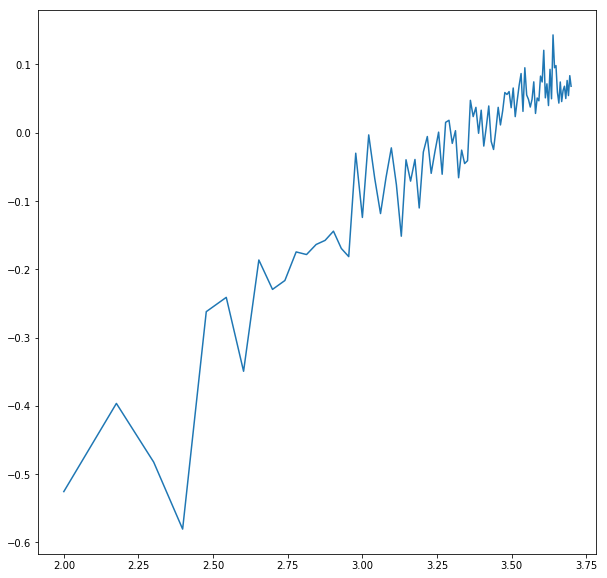

In [36]:
plt.plot(np.log10(samp_list),np.log10(intercept_vs_samp))
plt.show()

51
51
51
53


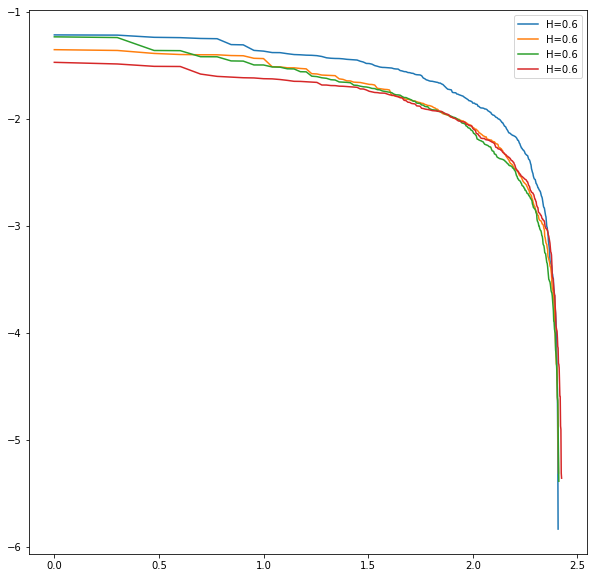

In [26]:
plt.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure()
ax= fig.add_subplot(111)
get_wavelet_var('haar',0.6,1024,est_sil=1,plot_sil=0)
get_wavelet_var('db2',0.6,1024,est_sil=1,plot_sil=0)
get_wavelet_var('db4',0.6,1024,est_sil=1,plot_sil=0)
get_wavelet_var('db20',0.6,1024,est_sil=1,plot_sil=0)
#get_wavelet_var('haar',0.3,16384,est_sil=0,plot_sil=0)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()


7
-0.0442810589026 0.462922826742


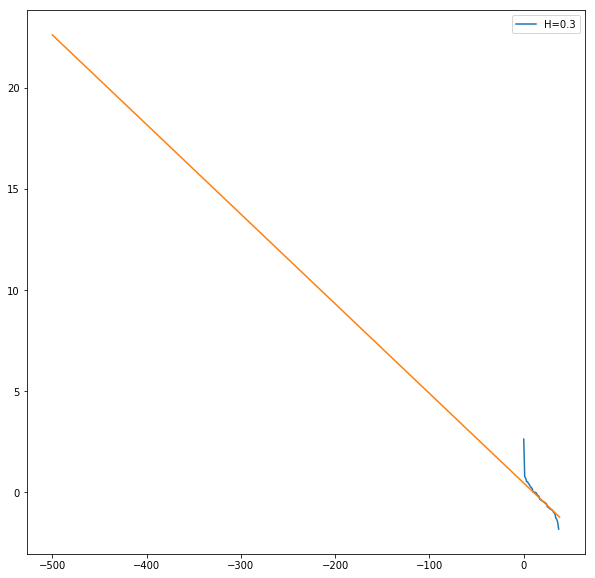

In [11]:
import pywt

def Lf(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

def Qf(x, A, B,C): # this is your 'straight line' y=f(x)
    return A*x**2 + B*x + C

def get_wavelet_var(wavelet,H=0.3,samp_size=150,est_sil=0,plot_sil=0,print_sil=0):
    
    f = FBM(n=samp_size, hurst=H, length=0.5, method='daviesharte')
    # Generate a fBm realization
    fbm_sample = f.fbm()
    # Get the times associated with the fBm
    t_values = f.times()
    cA, cD = pywt.dwt(fbm_sample, wavelet)
    
    M=len(cD)
    #print(M)
    R=np.zeros(M+1) #Autocorrelation: r[0] to r[p-1]

    for k in range(M+1):
        cD_shift=shift(cD, k, cval=0)
        R[k]=np.sum(cD*np.conjugate(cD_shift))

    AutoCorr_mat=toeplitz(R[0:M],R[0:M])

    M=len(cD)//2
    #print(M)
    AutoCorr_mat_orig=np.zeros((M+1,M+1))
    for j in range(M+1):
        orig_seq=fbm_sample[j:M+j]
        for k in range(M+1):
            shift_seq=fbm_sample[k:M+k]
            AutoCorr_mat_orig[j][k]=np.sum(orig_seq*np.conjugate(shift_seq))
    
    U,S,V=svd(AutoCorr_mat_orig)
    num_elem=int(0.2*M)
    if(print_sil!=1):
        print(num_elem)
    if(est_sil!=1):
        if(num_elem%2==1):
            A,B = curve_fit(Lf,(np.arange(num_elem)+M//2-num_elem//2)\
                                ,np.log10(S[M//2-num_elem//2:M//2+num_elem//2+1]))[0] # your data x, y to fit
        else:
            A,B = curve_fit(Lf,(np.arange(num_elem)+M//2-num_elem//2)\
                            ,np.log10(S[M//2-num_elem//2:M//2+num_elem//2]))[0] # your data x, y to fit
        #print(A,B)
    if(plot_sil!=1):
        ax.plot(np.arange(M)\
                ,np.log10(S[0:M]),label=str("H="+str(H)))
        if(est_sil!=1):
            plt.plot([-500,M],[B-500*A,A*(M)+B])
            
    if(est_sil!=1):
        if(print_sil!=1):
            print(A,B)
        return B

plt.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure()
ax= fig.add_subplot(111)
get_wavelet_var('haar',0.3)
# get_wavelet_var('haar',0.3,plot_sil=0)
# get_wavelet_var('haar',0.5,plot_sil=0)
# get_wavelet_var('haar',0.7,plot_sil=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()